In [4]:
import os
from importlib import reload

import torch
import numpy as np
import sciplots as plots
from sklearn.decomposition import PCA
from netloader.utils.utils import get_device

from src.utils.utils import open_config
from src.utils.data import DarkDataset, loader_init
from src.utils.clustering import CompactClusterEncoder

torch.serialization.add_safe_globals([CompactClusterEncoder])

In [6]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = config['output']['plots-directory']

bahamas_colours = ['#0008E0', '#004FE0', '#0097E0', '#00DCE0']
bahamas_agn_colours = ['#F54EDF', '#5D4EF5']
bahamas_dmo = ['#01FB3D', '#00FA8F', '#89FA00']
flamingo_colours = ['#FA2100', '#FABD00', '#FA7700']
flamingo_test = ['#FA07A0']
# colours = ['k'] + bahamas_dmo[:1] + bahamas_agn_colours + bahamas_colours[:1] + bahamas_colours[1:2] + bahamas_dmo[-1:] + bahamas_colours[-2:]
colours = ['k'] + bahamas_colours

In [34]:
known = [
    'bahamas_cdm',
    # 'bahamas_cdm_low',
    # 'bahamas_cdm_hi',
    'bahamas_0.1',
    'bahamas_0.3',
    'bahamas_1',
    # 'bahamas_dmo_cdm',
    # 'bahamas_dmo_0.1',
    # 'bahamas_dmo_1',
    # 'flamingo',
    # 'flamingo_low',
    # 'flamingo_hi',
    # 'darkskies_cdm',
    # 'darkskies_0.2'
]
# unknown = ['bahamas_dmo_cdm', 'bahamas_dmo_0.1', 'bahamas_dmo_1', 'noise']
unknown = [
    # 'flamingo_low_test',
    # 'bahamas_dmo_0.1',
    'noise',
    # 'darkskies_0.1',
]

dataset = DarkDataset(config['data']['data-dir'], known, unknown)
dataset.labels = dataset.unique_labels(dataset.labels, dataset.sims)

net = torch.load(os.path.join(config['output']['network-states-directory'], 'network_v10_24.10.0.pth'), weights_only=False)
net.to(get_device()[1])
net.transforms['inputs'][1]._shape = dataset.images.shape[1:]
dataset.images = net.transforms['inputs'](dataset.images)
dataset.labels = net.transforms['targets'](dataset.labels)
print(net)

loaders = loader_init(dataset, batch_size=config['training']['batch-size'], val_frac=config['training']['validation-fraction'], idxs=net.idxs)

data = net.predict(loaders[1])
# data['targets'] = dataset.correct_unknowns(data['targets'].squeeze())
# data['targets'] = dataset.unique_labels(data['targets'], dataset.sims[data['ids'].astype(int)])
data['targets'] = data['targets'].squeeze()
labels = dataset.names[data['ids'][np.unique(
    data['targets'],
    return_index=True,
)[1]].astype(int)].tolist()

Architecture: CompactClusterEncoder
Description: K, Log, NX, 1L, Noise, No FLAMINGO, No AGN, Final Training Choices
Network: network_v10
Epoch: 150
Optimiser: AdamW
Scheduler: ReduceLROnPlateau
Args: (method: median, center_step: [1.0, 1.0, 1.0, 1.0, 1.0], similarity_weight: 0, class_weight: 0.2, compact_weight: 0, distance_weight: 1, steps: 3, cluster_weight: 2.2)

Training data size: 14400	Validation data size: 3600
Prediction time: 3.655e-01 s


In [73]:
data['latent'][:, 0] *= 1e6
# pca = PCA(n_components=4).fit(data['latent'][np.isin(data['targets'], np.unique(data['targets'])[net._unknown:])])
pca = PCA(n_components=4).fit(data['latent'])
pca_transform = pca.transform(data['latent'])
pca_transform[:, 0] /= 1e6
data['latent'][:, 0] /= 1e6

In [79]:
latent = [[], []]
slice_ = slice(None)
# slice_ = slice(1, None)
for target in np.unique(data['targets'])[slice_]:
    idxs = data['targets'] == target
    latent[0].append(pca_transform[idxs, 0])
    latent[1].append(pca_transform[idxs, 1])

latent = np.array(latent, dtype=list)

-1.0948633 -0.4167938
-1.0948633 -1.1838797
-1.0948633 -1.128689
-1.0948633 -1.0635605
-1.0948633 -0.73054767


(-1.4771149158477783, 3.0844061374664307)

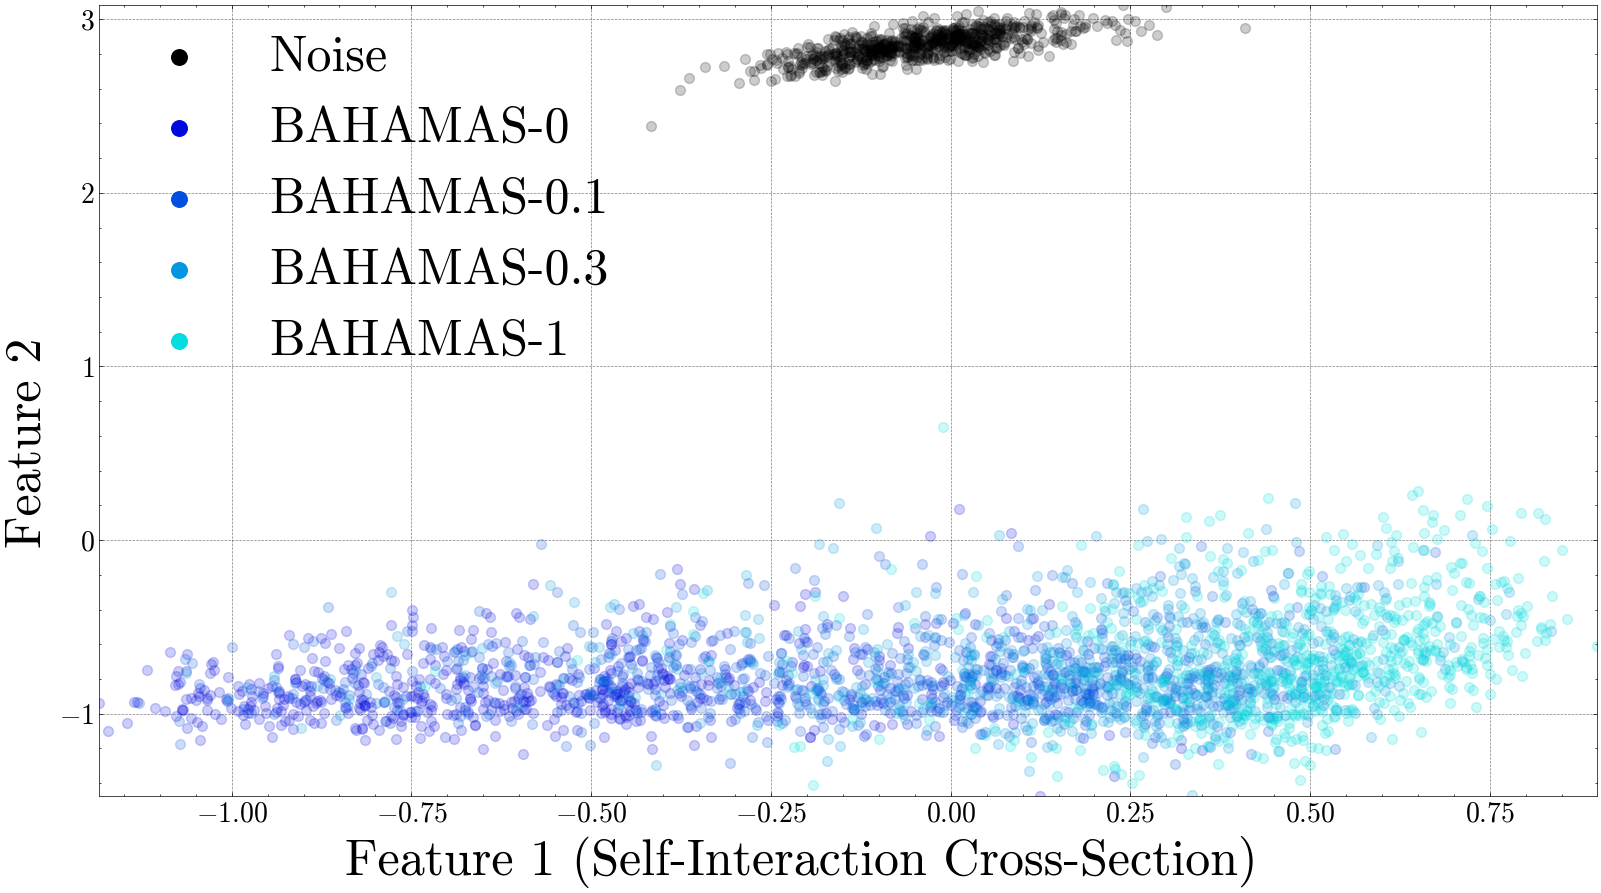

In [95]:
plot = plots.PlotPlots(
    latent[0],
    latent[1],
    # x_label='Feature 1',
    # y_label='Feature 2',
    x_label='Feature 1 (Self-Interaction Cross-Section)',
    y_label='Feature 2',
    alpha_marker=0.2,
    alpha_2d=0.2,
    major=36,
    colours=colours[slice_],
    labels=labels[slice_],
    styles='.',
    fig_size=(16, 9),
    axis=True,
    frameon=False,
    cols=1,
    loc='upper left'
)
# plot.set_axes_pad(pad=0.05)
plot.axes.set_xlim([np.min(pca_transform[:, 0]), np.max(pca_transform[:, 0])])
plot.axes.set_ylim([np.min(pca_transform[:, 1]), np.max(pca_transform[:, 1])])

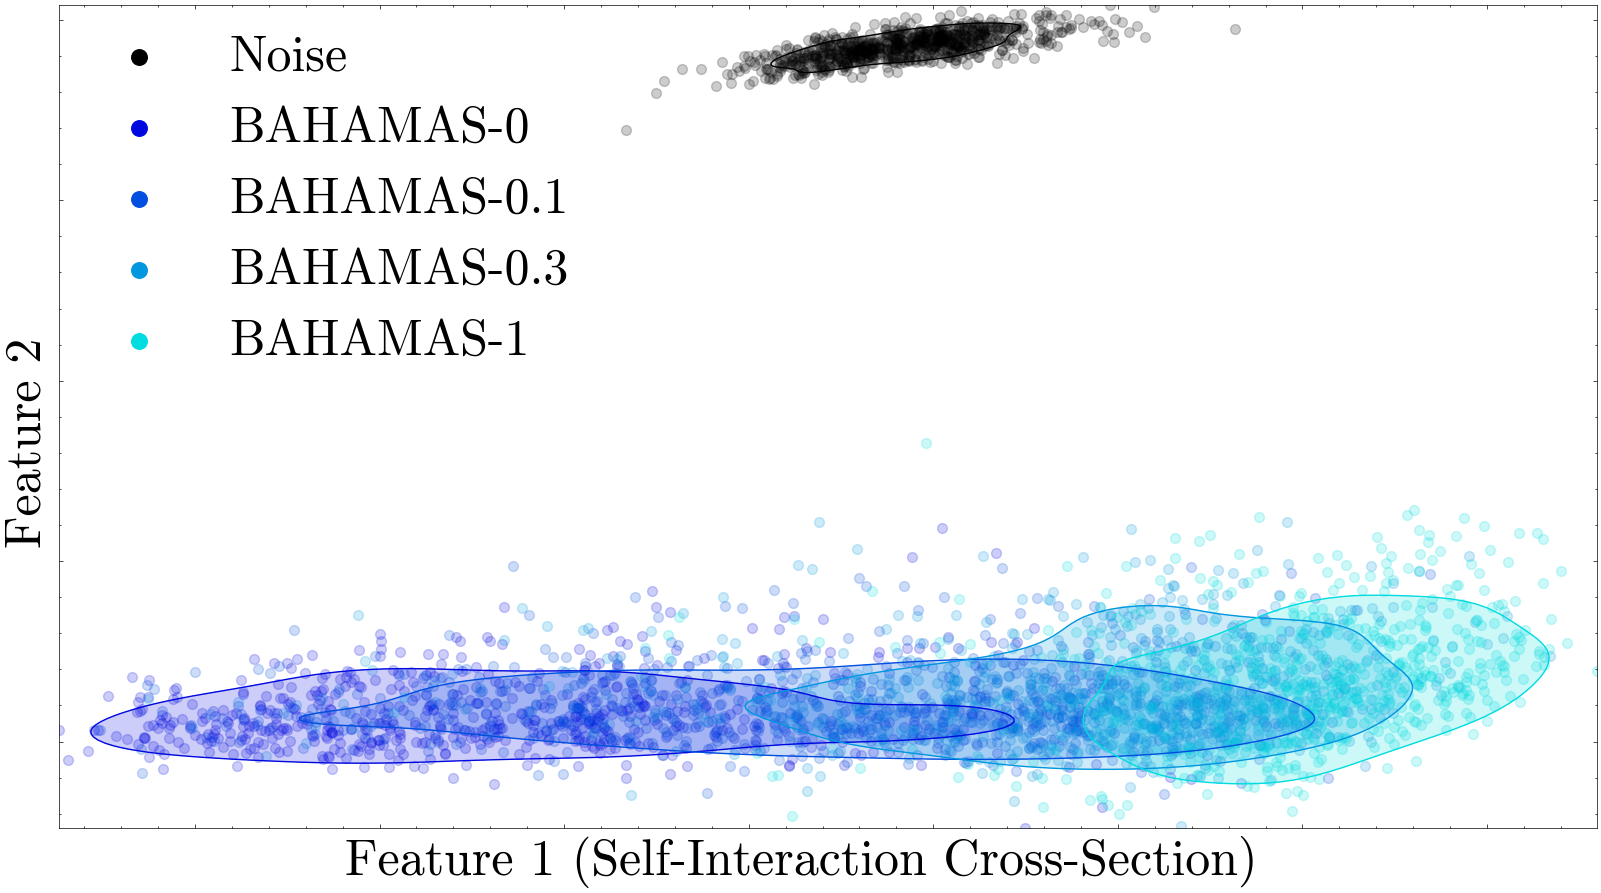

In [96]:
for colour, x_data, y_data in zip(colours[slice_], plot._data, plot._y_data):
    plot.plot_density(colour, np.stack((x_data, y_data), axis=-1), np.array(([np.min(x_data), np.max(x_data)], [np.min(y_data), np.max(y_data)])), plot.axes)

plot.axes.set_xticklabels([])
plot.axes.set_yticklabels([])
# plot.axes.set_xlim([np.min(pca_transform[:, 0]), np.max(pca_transform[:, 0])])
# plot.axes.set_ylim([np.min(pca_transform[:, 1]), np.max(pca_transform[:, 1])])
plot.axes.grid()
plot.create_legend(**plot._legend_kwargs)
# plot.plots = [plot for plot in plot.plots.copy() if isinstance(plot, Rectangle)]
plot.create_legend(**plot._legend_kwargs)
# plot.fig._supxlabel.set_fontsize(72)
# plot.fig._supylabel.set_fontsize(72)
plot.fig

In [201]:
plot.savefig('../plots/', name='test')

In [197]:
net = net.to('cpu')
torch.cuda.empty_cache()